In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-25 19:54:57 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-25 19:54:58 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-25 19:54:58 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-25 19:55:00 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-25 19:55:00 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-25 19:55:00 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-25 19:55:00 wandb.docker.auth DEBUG    No config file found


## Load LM and the Select Task

In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-25 19:55:03 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-25 19:55:03 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-10-25 19:55:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-25 19:55:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-25 19:55:03 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-25 19:55:47 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-25 19:55:47 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-25 19:55:48 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [6]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input
from src.selection.data import get_counterfactual_samples_within_task

In [7]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_n_distractors=5,
    clean_n_distractors=5
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(patch_sample.prompt(), ">>", patch_sample.obj)
print(clean_sample.prompt(), ">>", clean_sample.obj)

2025-10-25 19:55:51 src.selection.data INFO     clean_obj_idx=1 | ['Kettle', 'Car', 'Plum', 'Xylophone', 'Sweater', 'Table']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-25 19:55:52 src.selection.data INFO     Options: Strawberry, Saxophone, Airplane, Chair, Pen, Rabbit.
Which among these objects mentioned above is a fruit?
Answer:
2025-10-25 19:55:52 src.selection.data INFO     Kiwi | fruit -> Strawberry | pred=['" Strawberry"[89077] (p=0.695, logit=21.250)', '" The"[578] (p=0.155, logit=19.750)', '" Among"[22395] (p=0.073, logit=19.000)', '" A"[362] (p=0.024, logit=17.875)', '" strawberry"[73700] (p=0.005, logit=16.375)']
2025-10-25 19:55:52 src.selection.data INFO     Options: Kettle, Car, Plum, Xylophone, Sweater, Table.
Which among these objects mentioned above is a vehicle?
Answer:
2025-10-25 19:55:52 src.selection.data INFO     Truck | vehicle -> Car | pred=['" Car"[3341] (p=0.648, logit=22.500)', '" The"[578] (p=0.164, logit=21.125)', '" A"[362] (p=0.100, logit=20.625)', '" Among"[22395] (p=0.047, logit=19.875)', '" K"[735] (p=0.005, logit=17.625)']
2025-10-25 19:55:52 src.selection.

## Training Set

In [10]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

train_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
    # "profession",
    # "nationality",
    # "landmarks"
    # "rhymes"
)

os.makedirs(train_samples_save_path, exist_ok=True)


free_gpu_cache()
train_set = []
train_limit = 1024
start_from = 1

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

while len(train_set) < train_limit:
    print(f"sample {len(train_set)+1} / {train_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(2, 6)),
    )
    train_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            train_samples_save_path,
            f"{len(train_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(train_set)

sample 1 / 1024
2025-10-11 16:47:14 src.selection.data INFO     clean_obj_idx=0 | ['Library', 'Celery', 'Bangle']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-11 16:47:15 src.selection.data INFO     # Options: Church, Slow cooker, Lettuce.
Which among these objects mentioned above is a vegetable?
Answer:
2025-10-11 16:47:15 src.selection.data INFO     Tomato | vegetable -> Lettuce | pred=['" Let"[6771] (p=0.746, logit=27.125)', '" Among"[21658] (p=0.115, logit=25.250)', '" The"[576] (p=0.101, logit=25.125)', '" To"[2014] (p=0.020, logit=23.500)', '" \n"[715] (p=0.006, logit=22.250)']
2025-10-11 16:47:15 src.selection.data INFO     # Options: Library, Celery, Bangle.
Which among these objects mentioned above is a building?
Answer:
2025-10-11 16:47:15 src.selection.data INFO     Church | building -> Library | pred=['" Library"[11635] (p=0.949, logit=31.750)', '" The"[576] (p=0.022, logit=28.000)', '" Among"[21658] (p=0.012, logit=27.375)', '" To"[2014] (p=0.007, logit=26

1024

In [11]:
from src.selection.data import CounterFactualSamplePair
import random

train_set = []
train_limit = 1024

train_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks",
    # "rhymes",
)

sample_files = [
    os.path.join(train_samples_load_path, f)
    for f in os.listdir(train_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:train_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    # patch_category = cf_pair.patch_sample.category
    # random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    # random_obj = random.choice(select_task.category_wise_examples[random_category])
    # cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    train_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(train_set)

2025-10-11 17:10:56 __main__ INFO     Found 1024 sample files


1024

In [12]:
destination, source = random.choice(train_set)
print("Destination:", destination.prompt(), ">>", destination.obj)
print("Source:", source.prompt(), ">>", source.obj)

Destination: # Options: Rose, Ukulele, Bookshelf, Pants, Dog.
Which among these objects mentioned above is a clothing?
Answer: >> Pants
Source: # Options: Drum, Tractor, Chair, Gloves, Dumbbell.
Which among these objects mentioned above is a music instrument?
Answer: >> Drum


## Validation Set

In [8]:
# from src.selection.data import CounterFactualSamplePair
# from src.functional import free_gpu_cache
# from src.selection.data import get_counterfactual_samples_interface
# import random

# # data_type = "objects"
# data_type = "profession"
# # data_type = "nationality"
# select_val_task = TASK_CLS.load(
#     path=os.path.join(
#         env_utils.DEFAULT_DATA_DIR, 
#         "selection", 
#         f"{data_type}.json"
#     )
# )

# validation_samples_save_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection",
#     "samples",
#     "validation",
#     mt.name.split("/")[-1],
#     select_val_task.task_name,
#     data_type,
# )

# os.makedirs(validation_samples_save_path, exist_ok=True)

    
# free_gpu_cache()
# validation_set = []
# validation_limit = 512
# start_from = 0

# counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

# while len(validation_set) < validation_limit:
#     print(f"sample {len(validation_set)+1} / {validation_limit}")
#     patch, clean = counterfactual_sampler(
#         mt=mt,
#         task=select_val_task,
#         filter_by_lm_prediction=True,
#         prompt_template_idx=3,
#         option_style=OPTION_STYLE,
#         n_distractors=random.choice(range(2, 6)),
#     )
#     validation_set.append((clean, patch))
#     cf_pair = CounterFactualSamplePair(
#         patch_sample=patch,
#         clean_sample=clean,
#     )
#     cf_pair.detensorize()
#     with open(
#         os.path.join(
#             validation_samples_save_path,
#             f"{len(validation_set) + start_from - 1:05d}.json",
#         ),
#         "w",
#     ) as f:
#         json.dump(cf_pair.to_dict(), f, indent=2)

# len(validation_set)

In [63]:
from src.selection.data import CounterFactualSamplePair
import random

data_type = "profession"
# data_type = "objects"

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    data_type,
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-10-25 20:27:24 __main__ INFO     Found 512 sample files


512

## Debug SVD patching logic

In [13]:
clean_sample, patch_sample = train_set[17]
print(clean_sample.prompt(), ">>", clean_sample.obj)
print(patch_sample.prompt(), ">>", patch_sample.obj)

Options: Air fryer, Jacket, Strawberry.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Air fryer
Options: Toothbrush, Toaster, Dress.
Which among these objects mentioned above is a clothing?
Answer: >> Dress


In [14]:
import baukit
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from src.functional import get_module_nnsight

###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = get_module_nnsight(mt._model, mt.attn_module_name_format.format(0)).head_dim
query_idx = -1  # almost always the last token
###################################################################################

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layer_idx, head_idx = (35, 19)

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    print(f"{q_proj_module.output.shape=}")
    patch_q_proj = (
        q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim)
        .transpose(1, 2)
        .save()
    )
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

q_proj_module.output.shape=torch.Size([1, 25, 4096])


In [15]:
patch_q_proj.shape

torch.Size([1, 32, 25, 128])

In [16]:
head_q_out = patch_q_proj[:, head_idx, query_idx, :]
head_inp = patch_ln[:, query_idx, :]

head_q_out.shape, head_inp.shape

(torch.Size([1, 128]), torch.Size([1, 4608]))

In [17]:
q_proj_2 = (
    attn_block.q_proj(head_inp)
    .view(batch_size, 1, n_heads, head_dim)
    .transpose(1, 2)
)
head_q_out_2 = q_proj_2[:, head_idx, query_idx, :]
torch.allclose(head_q_out, head_q_out_2, atol=1e-3)

False

In [18]:
attn_block = baukit.get_module(mt._model, attn_block_name)
q_proj_per_head = attn_block.q_proj.weight.T.view(attn_block.q_proj.in_features, n_heads, head_dim)
q_proj_per_head.shape

torch.Size([4608, 32, 128])

In [19]:
q_proj_head = q_proj_per_head[:, head_idx, :]
q_proj_head.shape

torch.Size([4608, 128])

In [21]:
torch.allclose(
    head_q_out_2,
    torch.matmul(head_inp, q_proj_head),
    atol=1e-2
)

True

In [22]:
from src.utils.typing import SVD
svd = SVD.calculate(q_proj_head)
svd.U.shape, svd.S.shape, svd.V.shape

(torch.Size([4608, 128]), torch.Size([128]), torch.Size([128, 128]))

In [23]:
masks = torch.zeros_like(svd.S)
masks[:5] = 1.0
U_k = svd.U * masks[None, :]        # 8192 × 128
S_k = svd.S * masks                 # 128
Vh_k = svd.V.T * masks[:, None]     # 128 × 128

# Reconstruct the rank-5 approximation of q_proj_head
q_proj_head_rank5 = U_k @ torch.diag(S_k) @ Vh_k  # 8192 × 128

# Project the input through the rank-5 transformation
q_out_proj_1 = head_inp @ q_proj_head_rank5  # 1 × 128

torch.allclose(
    q_out_proj_1,
    head_q_out @ Vh_k.T @ Vh_k,
    atol=1e-2
)

False

### Saving the SVD of the query projection matrix per head

In [27]:
from tqdm.auto import tqdm
import baukit

head_svd_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "q_proj_svd",
    mt.name.split("/")[-1],
)

os.makedirs(head_svd_save_path, exist_ok=True)
for layer_idx in tqdm(range(mt.n_layer)):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    q_proj_per_head = attn_block.q_proj.weight.T.view(attn_block.q_proj.in_features, n_heads, head_dim)
    for head_idx in range(n_heads):
        q_proj_head = q_proj_per_head[:, head_idx, :]
        svd = SVD.calculate(q_proj_head)
        with open(os.path.join(head_svd_save_path, f"{layer_idx}_{head_idx}.pt"), "wb") as f:
            torch.save(svd, f)

  0%|          | 0/46 [00:00<?, ?it/s]

### Loading the SVD of the query projection matrix per head

In [24]:
from tqdm.auto import tqdm
from src.functional import free_gpu_cache, get_module_nnsight
from src.utils.typing import SVD

head_svd_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "q_proj_svd",
    mt.name.split("/")[-1],
)

q_proj_basis_directions = {}
head_dim = get_module_nnsight(mt._model, mt.attn_module_name_format.format(0)).head_dim
n_embd = mt.n_embd
n_heads = mt.config.num_attention_heads

for layer_idx in tqdm(range(mt.n_layer)):
    for head_idx in range(n_heads):
        with open(os.path.join(head_svd_load_path, f"{layer_idx}_{head_idx}.pt"), "rb") as f:
            svd = torch.load(f, weights_only=False)
        assert isinstance(svd, SVD)
        assert svd.U.shape == (n_embd, head_dim)
        assert svd.S.shape == (head_dim,)
        assert svd.V.shape == (head_dim, head_dim)

        q_proj_basis_directions[(layer_idx, head_idx)] = svd.V.T.to(mt.dtype) #! the transpose here is important!

  0%|          | 0/46 [00:00<?, ?it/s]

In [29]:
baukit.get_module(
        mt._model, mt.attn_module_name_format.format(0)
    ).head_dim

128

In [25]:
len(q_proj_basis_directions)

1472

In [26]:
q_proj_basis_directions[(35, 19)].shape

torch.Size([128, 128])

## optimization logic

In [44]:
from src.utils.typing import PathLike
from torch.optim import AdamW
from src.functional import free_gpu_cache
from src.tokens import TokenizerOutput
from typing import Literal
from src.selection.optimization import promote_target_suppress_distractors, match_gold_logit_distribution, cache_q_projections_prev
import numpy as np

def apply_q_proj_patch_with_projection(
    mt: ModelandTokenizer,
    source_tokenized: TokenizerOutput,
    destination_tokenized: TokenizerOutput,
    projections: dict[tuple[int, int], torch.Tensor],
    token_indices: list[int],
):
    q_proj_modules = []
    layer_to_heads = {}
    query_locations = []
    for layer_idx, head_idx in projections.keys():
        module_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        q_proj_modules.append(module_name)
        if layer_idx not in layer_to_heads:
            layer_to_heads[layer_idx] = []
        layer_to_heads[layer_idx].append(head_idx)
        query_locations.extend(
            (layer_idx, head_idx, query_idx)
            for query_idx in token_indices
        )

    q_projections = cache_q_projections_prev(
        mt=mt,
        input=source_tokenized,
        query_locations=query_locations,
        return_output=False,
    )
    patches = {}
    for (layer_idx, head_idx, query_idx), q_proj in q_projections.items():
        module_name = (
            mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        )
        patches[(module_name, head_idx)] = (layer_idx, q_proj)
    
    patch_q_states = patches
    n_heads = mt.config.num_attention_heads
    head_dim = get_module_nnsight(
        mt._model, mt.attn_module_name_format.format(0)
    ).head_dim
    batch_size = destination_tokenized.input_ids.shape[0]
    seq_len = destination_tokenized.input_ids.shape[1]

    def perform_patch(repr, layer_name):
        if layer_name not in q_proj_modules:
            return repr
        # logger.debug(f"Patching at layer: {layer_name}")
        layer_idx = int(layer_name.split(".")[2])
        repr = repr.view(batch_size, seq_len, n_heads, head_dim).transpose(1, 2)
        for head_idx in layer_to_heads[layer_idx]:
            if (layer_idx, head_idx) not in projections:
                assert False, f"{(layer_idx, head_idx)} not in projections. This should never happen!"
            projection = projections[(layer_idx, head_idx)]
            q_clean = repr[:, head_idx, token_indices, :]
            layer_idx, q_patch = patch_q_states[(layer_name, head_idx)]
            q_patch = q_patch.clone().to(q_clean.dtype).to(q_clean.device)
            if q_patch.dim() == 2 and q_clean.dim() == 3:
                q_patch = q_patch.unsqueeze(1)  # Now [batch, 1, head_dim]
            q_patch_proj = q_patch @ projection
            q_clean_proj = q_clean @ projection
            repr[:, head_idx, token_indices, :] += (q_patch_proj - q_clean_proj)

        repr = repr.transpose(1, 2).view(
            batch_size, seq_len, n_heads * head_dim
        )
        return repr

    with baukit.TraceDict(
        module=mt._model, layers=q_proj_modules, edit_output=perform_patch
    ):
        output = mt._model(**destination_tokenized)

    return output


def get_optimal_component_mask(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    q_proj_basis_directions: dict[tuple[int, int], torch.Tensor],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_indices: int = [-1],
    save_path: PathLike | None = None,
    save_step: int = 5,
    loss_fn: Literal["promote_suppress", "match_gold"] = "match_gold",
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
        "loss_fn": loss_fn,
    }
    loss_fn = {
        "promote_suppress": promote_target_suppress_distractors,
        "match_gold": match_gold_logit_distribution,
    }[loss_fn]
    logger.debug(f"Training with hparams: {hparams}")
    # n_layer = mt.n_layer
    # n_heads = mt.config.num_attention_heads
    head_dim = get_module_nnsight(
        mt._model, mt.attn_module_name_format.format(0)
    ).head_dim

    masks = {}
    for layer_idx, head_idx in q_proj_basis_directions.keys():
        masks[(layer_idx, head_idx)] = torch.ones(
            (head_dim,), dtype=mt.dtype, requires_grad=True, device=mt.device
        )

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    optimizer = AdamW([mask for mask in masks.values()], lr=learning_rate)
    losses = []

    all_q_proj_modules = []
    query_locations = []
    all_heads = list(q_proj_basis_directions.keys())
    for layer_idx, head_idx in all_heads:
        module_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        all_q_proj_modules.append(module_name)
        query_locations.extend(
            (layer_idx, head_idx, query_idx)
            for query_idx in query_indices
        )

    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    def build_projections(masks):
        projections = {}
        for layer_idx, head_idx in all_heads:
            basis_directions = q_proj_basis_directions[(layer_idx, head_idx)]
            mask = masks[(layer_idx, head_idx)].to(basis_directions.dtype).to(basis_directions.device)
            masked_basis = basis_directions * mask[:, None]
            projections[(layer_idx, head_idx)] = masked_basis.T @ masked_basis
        return projections

    @torch.no_grad()
    def save_projections(save_file: PathLike):
        os.makedirs(os.path.dirname(save_file), exist_ok=True)
        optimal_masks = {key: mask.clone().round() for key, mask in masks.items()}
        with torch.no_grad():
            final_projections = build_projections(optimal_masks)
        torch.save(
            {"projections": final_projections, "masks": optimal_masks, "hparams": hparams},
            save_file,
        )
        del optimal_masks, final_projections
        free_gpu_cache()
        return

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )

            projections = build_projections(masks=masks)

            output = apply_q_proj_patch_with_projection(
                mt=mt,
                source_tokenized=patch_tokenized,
                destination_tokenized=clean_tokenized,
                projections=projections,
                token_indices=query_indices,
            )

            logits = output.logits[:, -1, :]

            target_loss, loss_dict = loss_fn(
                mt=mt,
                source_samples=patch_samples,
                destination_samples=clean_samples,
                patched_logits=logits,
            )

            # mask loss
            mask_l1_loss = None
            for mask in masks.values():
                mask = mask.float()
                if mask_l1_loss is None:
                    mask_l1_loss = lamb * mask.norm(p=1)
                else:
                    mask_l1_loss += lamb * mask.norm(p=1).to(mask_l1_loss.device)

            loss = target_loss.float() + mask_l1_loss
            # loss = mask_l1_loss
            loss_dict_indv = (
                f"{', '.join([f'{k}={v:.3f}' for k, v in loss_dict.items()])}"
            )
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} [{loss_dict_indv}] + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            # checking if gradients are flowing
            # for key, mask in list(masks.items())[:5]:
            #     if mask.grad is not None:
            #         print(f"{key}: grad norm = {mask.grad.norm().item():.6f}")
            #     else:
            #         print(f"{key}: NO GRADIENT!")
            optimizer.step()

            with torch.no_grad():
                for mask in masks.values():
                    mask.clamp_(0, 1)
                    # mask += 1e-4  # to avoid zero gradients

            # print(f"Mask sample values: {list(masks.values())[0][:5]}")  # First 5 elements
            # print(f"Mask mean: {list(masks.values())[0].mean().item()}")

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

        mt._model.zero_grad()
        del (
            projections,
            output,
            logits,
        )
        free_gpu_cache()

        if save_path is not None and (
            (epoch + 1) % save_step == 0 or (epoch + 1) == n_epochs
        ):
            weight_path = os.path.join(save_path, f"epoch_{epoch+1}.pt")
            os.makedirs(os.path.dirname(weight_path), exist_ok=True)
            save_projections(save_file=weight_path)
            logger.info(f"Saved optimal projections to {weight_path}")

    final_masks = {key: mask.detach().round() for key, mask in masks.items()}
    final_projections = build_projections(final_masks)
    free_gpu_cache()
    return final_projections, final_masks, losses

In [28]:
mt._model.zero_grad()
free_gpu_cache()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_svd_proj",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

projections, masks, losses = get_optimal_component_mask(
    mt=mt,
    train_set=train_set,
    q_proj_basis_directions=q_proj_basis_directions,
    query_indices=[-1],
    save_path=optimized_path,
    loss_fn="match_gold",
    learning_rate=1e-2,
    n_epochs=10,
    lamb=1e-4,
    batch_size=32,
    save_step=5,
)

2025-10-09 14:37:16 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 10, 'lamb': 0.0001, 'batch_size': 32, 'loss_fn': 'match_gold'}
2025-10-09 14:37:16 __main__ INFO     Starting training...
2025-10-09 14:37:18 __main__ DEBUG    Epoch=1 | batch_idx=0 |>> 3.4375 [kldiv_loss=3.438] + 18.8418 = 22.2793
2025-10-09 14:37:25 __main__ DEBUG    Epoch=1 | batch_idx=1 |>> 2.4688 [kldiv_loss=2.469] + 18.6542 = 21.1230
2025-10-09 14:37:30 __main__ DEBUG    Epoch=1 | batch_idx=2 |>> 3.3125 [kldiv_loss=3.312] + 18.4924 = 21.8049
2025-10-09 14:37:34 __main__ DEBUG    Epoch=1 | batch_idx=3 |>> 4.0312 [kldiv_loss=4.031] + 18.3376 = 22.3688
2025-10-09 14:37:38 __main__ DEBUG    Epoch=1 | batch_idx=4 |>> 3.3438 [kldiv_loss=3.344] + 18.1862 = 21.5299
2025-10-09 14:37:43 __main__ DEBUG    Epoch=1 | batch_idx=5 |>> 2.7656 [kldiv_loss=2.766] + 18.0371 = 20.8027


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.20 GiB. GPU 0 has a total capacity of 79.25 GiB of which 1.81 GiB is free. Process 714223 has 41.46 GiB memory in use. Process 760951 has 8.38 GiB memory in use. Including non-PyTorch memory, this process has 27.57 GiB memory in use. Of the allocated memory 21.76 GiB is allocated by PyTorch, and 5.31 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_svd_proj",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

loaded_opt_results = torch.load(os.path.join(optimized_path, "epoch_10.pt"), weights_only=False)
loaded_opt_results.keys()

dict_keys(['projections', 'masks', 'hparams'])

In [26]:
loaded_opt_results["masks"].keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (

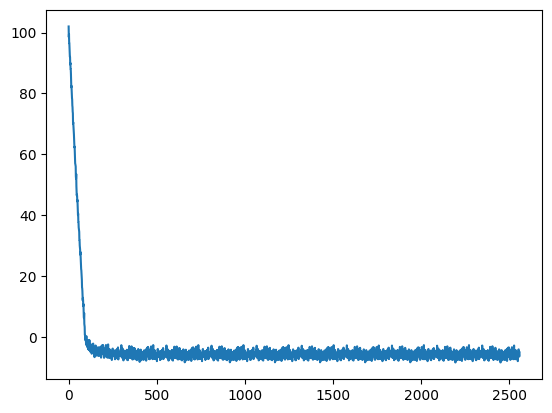

79


(True, True)

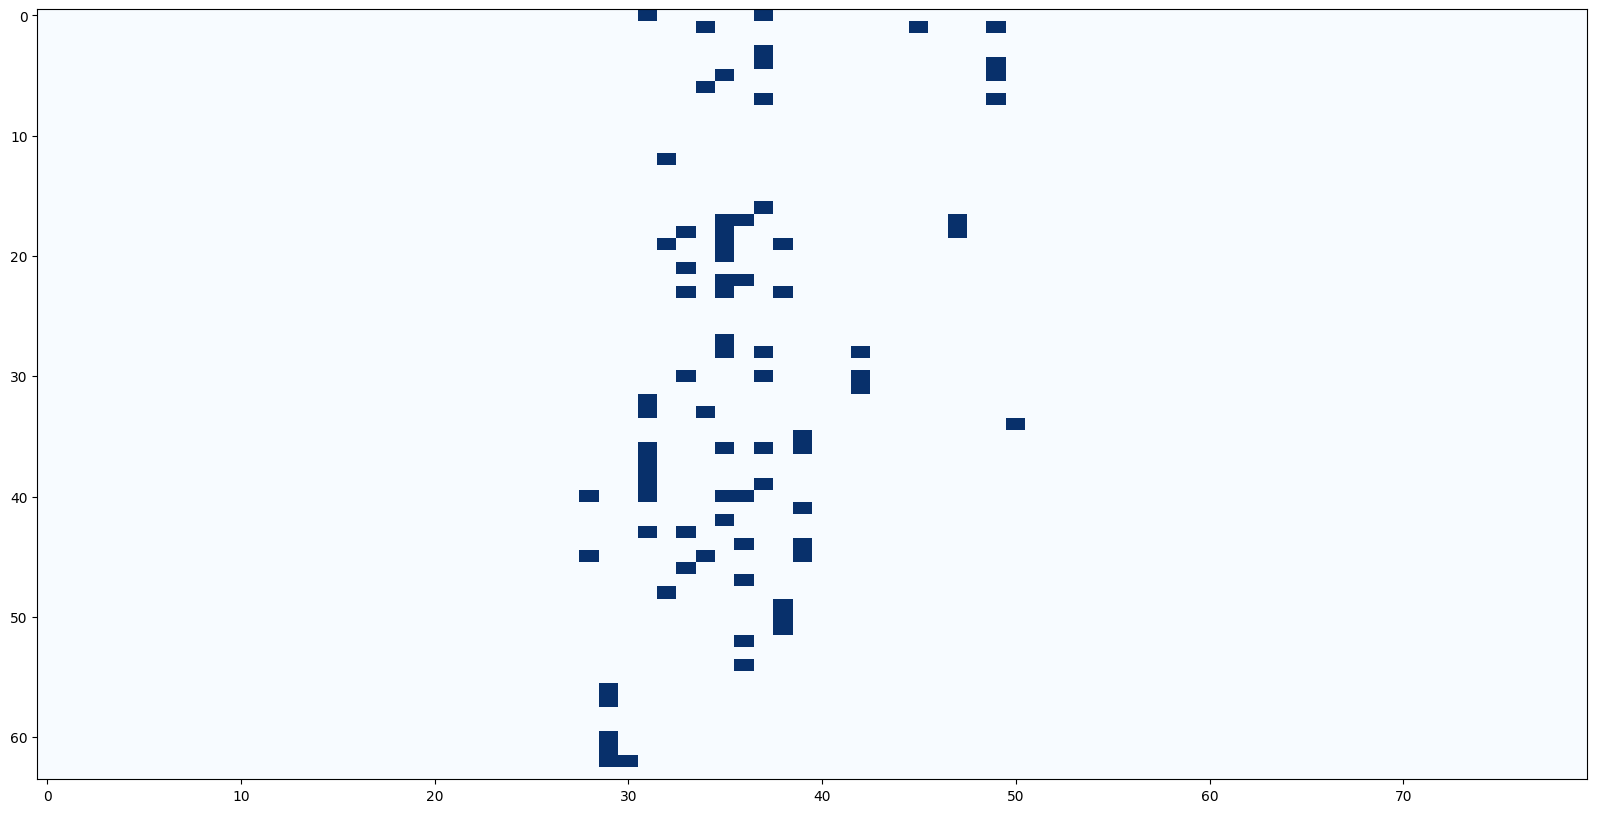

In [27]:
import sys

sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
from src.utils import env_utils
import os
import torch
plt.rcdefaults()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

2025-10-25 20:00:38 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb62db8ff50>
28 40
28 45
29 56
29 57
29 60
29 61
29 62
30 62
31 0
31 32
31 33
31 36
31 37
31 38
31 39
31 40
31 43
32 12
32 19
32 48
33 18
33 21
33 23
33 30
33 43
33 46
34 1
34 6
34 33
34 45
35 5
35 17
35 18
35 19
35 20
35 22
35 23
35 27
35 28
35 36
35 40
35 42
36 17
36 22
36 40
36 44
36 47
36 52
36 54
37 0
37 3
37 4
37 7
37 16
37 28
37 30
37 36
37 39
38 19
38 23
38 49
38 50
38 51
39 35
39 36
39 41
39 44
39 45
42 28
42 30
42 31
45 1
47 17
47 18
49 1
49 4
49 5
49 7
50 34


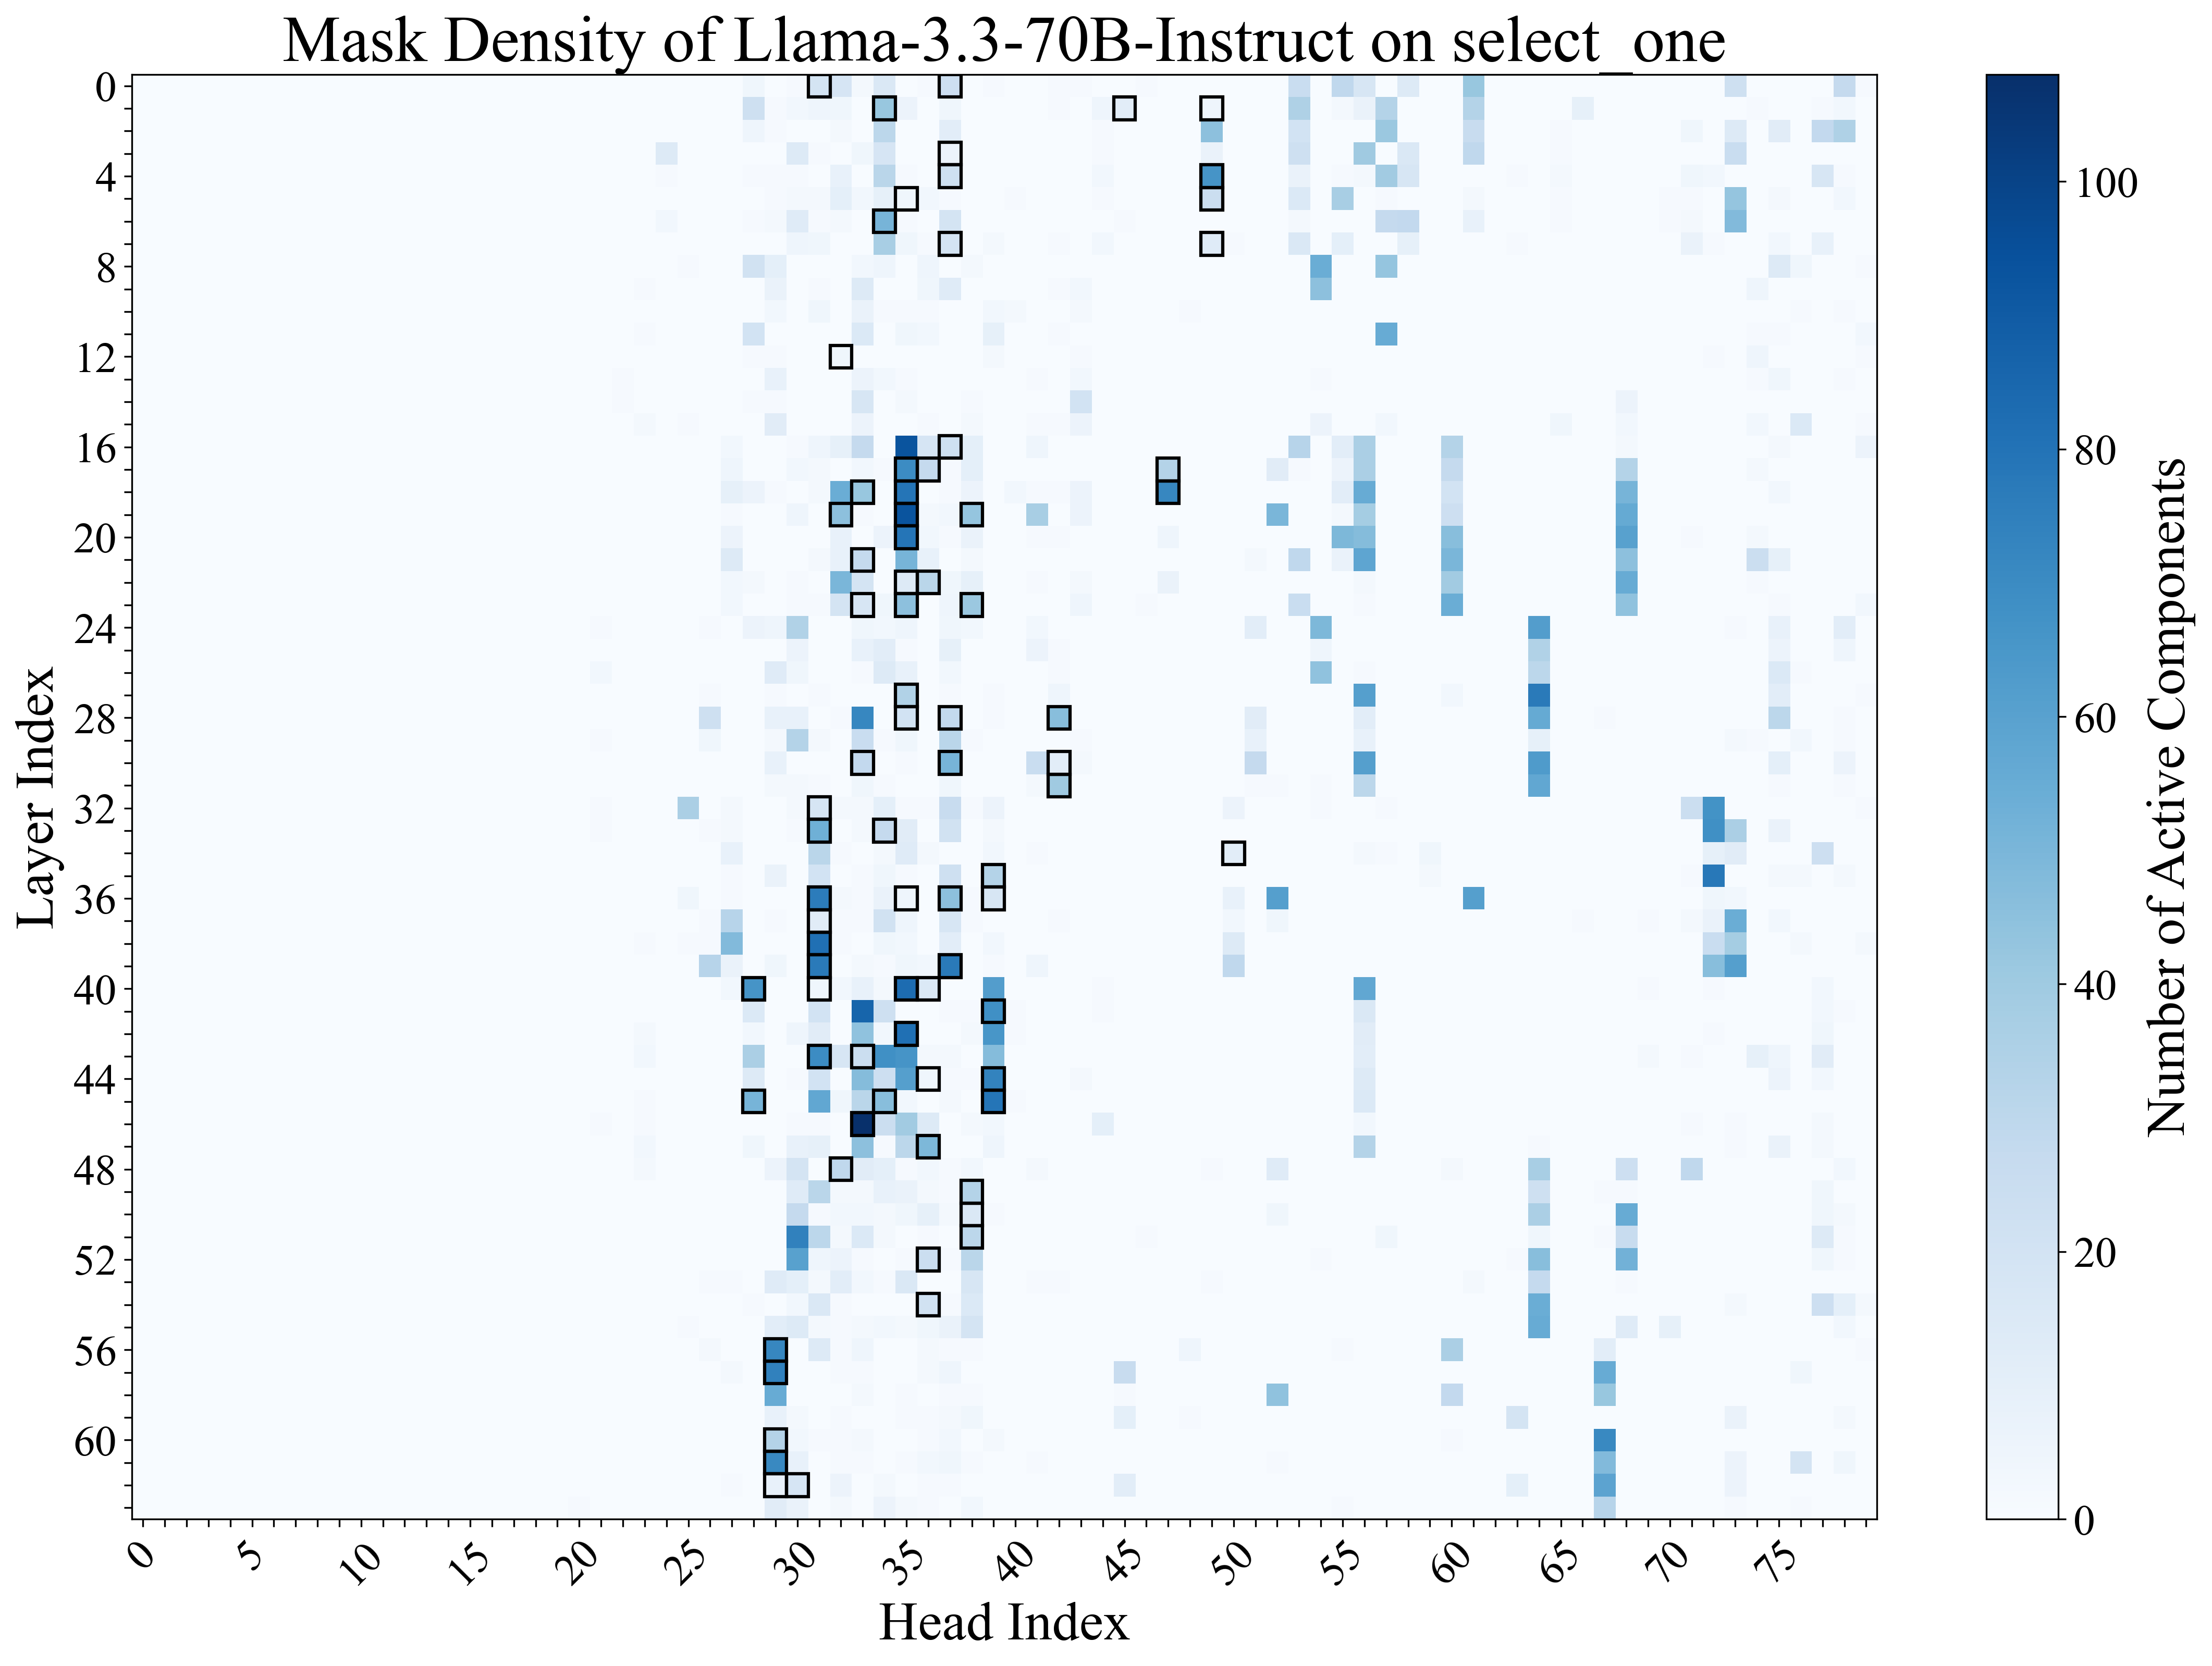

In [28]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.figure(figsize=(18, 12))
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

n_heads = mt.config.num_attention_heads
n_layer = mt.n_layer
mask_density = torch.zeros((n_heads, n_layer), dtype=torch.float32)

for (layer_idx, head_idx), mask in loaded_opt_results["masks"].items():
    mask_density[head_idx, layer_idx] = mask.sum().item()


def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

# plt.figure(figsize=(12, 6))
plt.imshow(mask_density.cpu(), cmap="Blues", aspect="auto")
plt.colorbar(label="Number of Active Components")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title(f"Mask Density of {mt.name.split('/')[-1]} on {select_task.task_name}")
plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_heads),
    labels=get_ticks(range(n_heads), skip=4),
)

ax = plt.gca()
# Draw borders around marked cells
for (x, y) in optimized_heads:
    print(x, y)
    # Create a Rectangle patch
    # Note: (x-0.5, y-0.5) positions the rectangle correctly around the cell
    # Width and height of 1 covers exactly one cell
    rect = patches.Rectangle(
        (x - 0.5, y - 0.5),  # bottom-left corner
        1,                     # width
        1,                     # height
        linewidth=1.5,          # border thickness
        edgecolor='black',    # border color (you can change this)
        facecolor='none'      # no fill, just border
    )
    ax.add_patch(rect)  # FIXED: This should be inside the loop!

plt.show()

## Validation

In [64]:
projections = loaded_opt_results["projections"]
masks = loaded_opt_results["masks"]

zero_proj_heads = []
for (layer_idx, head_idx), mask in masks.items():
    # if (
    #     mask.sum().item() == 0 
    #     or layer_idx >= 52
    # ):
    if (layer_idx, head_idx) not in optimized_heads:
        zero_proj_heads.append((layer_idx, head_idx))

print(len(projections), len(zero_proj_heads))

for layer_idx, head_idx in zero_proj_heads:
    if (layer_idx, head_idx) in projections:
        projections.pop((layer_idx, head_idx))

len(zero_proj_heads), len(projections)

79 5041


(5041, 79)

In [65]:
selected_heads = [
    (layer_idx, head_idx, masks[layer_idx, head_idx].sum().item())
    for (layer_idx, head_idx) in projections.keys()
]

selected_heads.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)
selected_heads[:10]

[(33, 46, 108.0),
 (35, 19, 93.0),
 (35, 40, 83.0),
 (35, 42, 81.0),
 (31, 38, 81.0),
 (39, 45, 79.0),
 (35, 20, 79.0),
 (35, 18, 79.0),
 (37, 39, 77.0),
 (31, 39, 77.0)]

In [66]:
import baukit

for (layer_idx, head_idx), projection in projections.items():
    module_device = baukit.get_module(
        mt._model, mt.attn_module_name_format.format(layer_idx)
    ).q_proj.weight.device
    projections[(layer_idx, head_idx)] = projection.to(module_device)


In [67]:
from src.selection.functional import find_quesmark_pos, interpret_logits
from src.selection.data import get_options_for_answer
from itertools import product
from src.functional import get_hs


@torch.no_grad()
def validate_low_rank_svd_bases_on_sample_pair(
    mt: ModelandTokenizer,
    destination_sample: SelectionSample,
    source_sample: SelectionSample,
    projections: dict[tuple[int, int], torch.Tensor],
    token_indices: list[int] = [-1],  # source_idx -> destination_idx
    must_track_tokens: list[int] = [],
    return_clean_predictions: bool = False,
    debug=False,
):
    destination_tokenized = prepare_input(
        prompts=destination_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )
    source_tokenized = prepare_input(
        prompts=source_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )

    destination_offset_mapping = destination_tokenized.pop("offset_mapping")[0]
    source_offset_mapping = source_tokenized.pop("offset_mapping")[0]

    ret_dict = {
        "source_sample": source_sample,
        "destination_sample": destination_sample,
    }
    logit_location = (mt.lm_head_name, -1)

    if return_clean_predictions or debug:
        source_hidden_states = get_hs(
            mt=mt,
            input=source_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        source_pred, interested_tokens = interpret_logits(
            tokenizer=mt,
            logits=source_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(source_sample)
            ]
            + must_track_tokens,
        )
        if return_clean_predictions:
            ret_dict["source_predictions"] = source_pred
            ret_dict["source_track"] = interested_tokens
        if debug:
            logger.debug(
                f"{source_sample.prompt()} >> {mt.tokenizer.decode(source_sample.ans_token_id)}"
            )
            logger.debug(f"Source pred : {[str(pred) for pred in source_pred]}")
            logger.debug(
                f"Source track: {[str(pred) for tok_id, (rank, pred) in interested_tokens.items()]}"
            )

        destination_logit = get_hs(
            mt=mt,
            input=destination_tokenized,
            locations=[logit_location],
            return_dict=False,
        ).squeeze()
        destination_pred, interested_tokens = interpret_logits(
            tokenizer=mt,
            logits=destination_logit,
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(destination_sample)
            ]
            + must_track_tokens,
        )
        if return_clean_predictions:
            ret_dict["destination_predictions"] = destination_pred
            ret_dict["destination_track"] = interested_tokens
        if debug:
            logger.debug(
                f"{destination_sample.prompt()} >> {mt.tokenizer.decode(destination_sample.ans_token_id)}"
            )
            logger.debug(
                f"Destination pred : {[str(pred) for pred in destination_pred]}"
            )
            logger.debug(
                f"Destination track: {[str(pred) for tok_id, (rank, pred) in interested_tokens.items()]}"
            )

    patched_output = apply_q_proj_patch_with_projection(
        mt=mt,
        source_tokenized=source_tokenized,
        destination_tokenized=destination_tokenized,
        projections=projections,
        token_indices=token_indices,
    )

    logits = patched_output.logits[:, -1, :]
    track_tokens = get_options_for_answer(destination_sample)
    track_token_ids = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in track_tokens
    ] + [
        source_sample.ans_token_id
    ]  # also track source ans
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt,
        logits=logits.squeeze(),
        interested_tokens=track_token_ids + must_track_tokens,
    )

    ret_dict["patched_predictions"] = patched_pred
    ret_dict["patched_track"] = patched_track

    if debug:
        logger.debug("-" * 100)
        logger.debug(
            f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
        )
        logger.debug(f"Patched pred : {[str(pred) for pred in patched_pred]}")
        logger.debug(
            f"Patched track: {[str(pred) for tok_id, (rank, pred) in patched_track.items()]}"
        )
        logger.debug("-" * 100)

    return ret_dict

In [68]:
import baukit
from src.functional import interpret_logits, get_module_nnsight
from src.selection.data import get_first_token_id, get_options_for_answer

destination_sample, source_sample = validation_set[12]
print("Source:", source_sample.prompt(), ">>", source_sample.obj)
print("Destination:", destination_sample.prompt(), ">>", destination_sample.obj)
print(
    f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
)

ret_dict = validate_low_rank_svd_bases_on_sample_pair(
    mt=mt,
    source_sample=source_sample,
    destination_sample=destination_sample,
    projections=projections,
    token_indices=[-1],
    must_track_tokens=[],
    return_clean_predictions=True,
    debug=True,
)

Source: Options: Ted Cruz, Zion Williamson, Jeff Bezos, Sadio Mané.
Who among these people mentioned above is a politician by profession?
Answer: >> Ted Cruz
Destination: Options: Jonathan Anderson, Jane Mayer, Vinícius Júnior, Hillary Clinton.
Who among these people mentioned above is a soccer player by profession?
Answer: >> Vinícius Júnior
target: Hillary Clinton | " Hillary"
2025-10-25 20:27:46 __main__ DEBUG    Options: Ted Cruz, Zion Williamson, Jeff Bezos, Sadio Mané.
Who among these people mentioned above is a politician by profession?
Answer: >>  Ted
2025-10-25 20:27:46 __main__ DEBUG    Source pred : ['" Ted"[23989] (p=0.867, logit=22.375)', '" The"[578] (p=0.071, logit=19.875)', '" Among"[22395] (p=0.026, logit=18.875)', '" ("[320] (p=0.012, logit=18.125)', '" "[220] (p=0.002, logit=16.500)']
2025-10-25 20:27:46 __main__ DEBUG    Source track: ['" Ted"[23989] (p=0.867, logit=22.375)', '" S"[328] (p=0.000, logit=13.375)', '" Jeff"[12149] (p=0.000, logit=13.000)', '" Zion"[414

In [69]:
from tqdm.auto import tqdm

validation_results = []
for destination, source in tqdm(validation_set):
    # destination = copy.deepcopy(destination)
    # source = copy.deepcopy(source)
    # destination.default_option_style = "bulleted"
    # source.prompt_template = select_task.prompt_templates[2]
    # destination.prompt_template = select_task.prompt_templates[2]

    # source_tokenized = prepare_input(prompts=[source.prompt()], tokenizer=mt)
    # destination_tokenized = prepare_input(prompts=[destination.prompt()], tokenizer=mt)

    track_tokens = {
        "clean_obj": destination.ans_token_id,
        "corrupt_obj": source.ans_token_id,
        "target_obj": destination.metadata["track_type_obj_token_id"],
    }

    pair_result = validate_low_rank_svd_bases_on_sample_pair(
        mt=mt,
        source_sample=source,
        destination_sample=destination,
        projections=projections,
        token_indices=[-1],
        must_track_tokens=list(track_tokens.values()),
        return_clean_predictions=True,
        debug=False,
    )
    das_patched_pred = pair_result["patched_predictions"]
    das_patched_track = pair_result["patched_track"]
    destination_pred = pair_result["destination_predictions"]
    destination_track = pair_result["destination_track"]

    validation_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": das_patched_pred,
            "patched_track": das_patched_track,
            "destination_pred": destination_pred,
            "destination_track": destination_track,
            "track_tokens": track_tokens,
        }
    )

  0%|          | 0/512 [00:00<?, ?it/s]

In [70]:
import numpy as np

track_token_types = ["clean_obj", "target_obj"]

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in validation_results:
        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }
    for key in attr:
        clean = np.array(attr[key]["clean"])
        patch = np.array(attr[key]["patch"])
        delta = patch - clean
        print(f"{key}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}")


top_1_accuracy = 0
failed_cases = []
for result in validation_results:
    target_tok_id = result["destination"].metadata["track_type_obj_token_id"]
    patched_track = result["patched_track"]
    if (
        patched_track[list(patched_track.keys())[0]][1].token_id == target_tok_id
    ):
        top_1_accuracy += 1

    else:
        failed_cases.append(result)

causality = top_1_accuracy / len(validation_results)
print(f"causality: {causality:.4f} ({top_1_accuracy} / {len(validation_results)})")
    

clean_obj
rank: clean 1.00 ± 0.04 -> patch 40.47 ± 68.33 | delta 39.47 ± 68.33
logit: clean 22.25 ± 0.72 -> patch 15.02 ± 2.96 | delta -7.23 ± 3.02
target_obj
rank: clean 64.75 ± 174.35 -> patch 1.89 ± 3.10 | delta -62.86 ± 174.30
logit: clean 13.81 ± 2.41 -> patch 20.80 ± 1.73 | delta 6.99 ± 2.80
causality: 0.7871 (403 / 512)


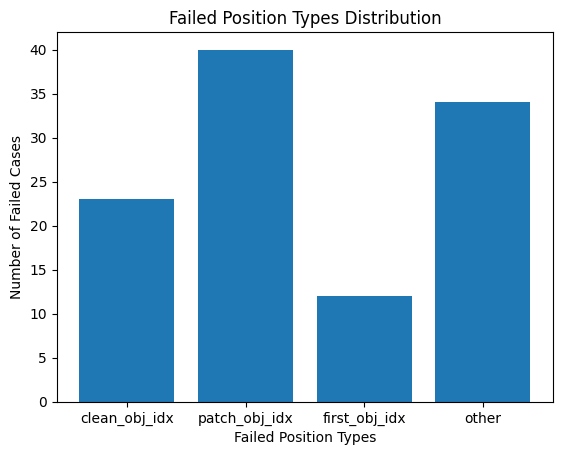

In [71]:
#! find the positions after the patched intervention.
# Is it looking at the first one, or the position of the 
# previous answer?

from src.functional import is_nontrivial_prefix

failed_pos_track = {
    "clean_obj_idx": [],
    "patch_obj_idx": [],
    "first_obj_idx": [],
    "other": []
}

for failed_case in failed_cases:
    clean_sample = failed_case["destination"]
    patch_sample = failed_case["source"]
    int_track = failed_case["patched_track"]
    clean_track = failed_case["destination_track"]
    clean_obj_idx = clean_sample.obj_idx
    patch_obj_idx = patch_sample.obj_idx

    int_top_tok = list(int_track.keys())[0]
    int_top_tok = int_track[int_top_tok][1].token.strip()
    int_top_obj = None
    for opt in clean_sample.options:
        if is_nontrivial_prefix(int_top_tok, opt):
            int_top_obj = opt
            break
    int_top_idx = clean_sample.options.index(int_top_obj)

    if int_top_idx == clean_obj_idx:
        failed_pos_track["clean_obj_idx"].append(failed_case)
    elif int_top_idx == patch_obj_idx:
        failed_pos_track["patch_obj_idx"].append(failed_case)
    elif int_top_idx == 0:
        failed_pos_track["first_obj_idx"].append(failed_case)
    else:
        failed_pos_track["other"].append(failed_case)


from matplotlib import pyplot as plt

plt.rcdefaults()
x_vals = failed_pos_track.keys()
y_vals = [len(failed_pos_track[key]) for key in x_vals]
plt.bar(x_vals, y_vals)
plt.xlabel("Failed Position Types")
plt.ylabel("Number of Failed Cases")
plt.title("Failed Position Types Distribution")
plt.show()

In [58]:
projection_path = "/disk/u/arnab/Codes/Projects/retrieval/results/selection/das_projections/sweep/Llama-3.3-70B-Instruct/256"
layer = mt.layer_name_format.format(36)

layer_proj_path = os.path.join(projection_path, layer)
assert os.path.exists(
    layer_proj_path
), f"Projection path {layer_proj_path} does not exist"
epoch_files = [
    f
    for f in os.listdir(layer_proj_path)
    if f.startswith("epoch_") and f.endswith(".pt")
]
epoch_files = sorted(
    epoch_files,
    key=lambda x: int(x.split("_")[1].split(".")[0]),
    reverse=True,
)
assert len(epoch_files) > 0, f"No epoch files found in {layer_proj_path}"
final_epoch_file = os.path.join(layer_proj_path, epoch_files[0])
logger.info(f"Loading projection from {final_epoch_file}")
optimal_rotator = torch.load(final_epoch_file, weights_only=False)

2025-10-25 20:14:06 __main__ INFO     Loading projection from /disk/u/arnab/Codes/Projects/retrieval/results/selection/das_projections/sweep/Llama-3.3-70B-Instruct/256/model.layers.36/epoch_010.pt


In [59]:
optimal_rotator.keys()

dict_keys(['model.layers.36'])